# 1. Подготовка датасета

На данном этапе производится загрузка и предварительная обработка датасетов для задачи детекции фишинговых email сообщений. Используются два датасета:
- **Nazario Phishing Corpus** (2015-2024) - коллекция фишинговых писем
- **Enron Email Dataset** - коллекция легитимных писем

**Важно**: Парсинг email, извлечение признаков и другие операции выполняются через модули системы (`src/email_parser.py`, `src/feature_extractor.py` и т.д.). В данном блокноте выполняется только загрузка и подготовка сырых данных.




In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Добавляем родительскую директорию в sys.path для импорта модулей как пакета
# Это позволяет использовать относительные импорты в модулях (например, .utils)
BASE_DIR = Path('../').resolve()
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))

# Настройка путей
DATA_RAW = BASE_DIR / 'data' / 'raw'
DATA_PROCESSED = BASE_DIR / 'data' / 'processed'

print(f"Рабочая директория: {BASE_DIR}")
print(f"Исходные данные: {DATA_RAW}")
print(f"Обработанные данные: {DATA_PROCESSED}")
print(f"sys.path содержит: {BASE_DIR}")


Рабочая директория: C:\Users\huzch\Documents\project\eml-phishing-analyzer
Исходные данные: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\raw
Обработанные данные: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\processed
sys.path содержит: C:\Users\huzch\Documents\project\eml-phishing-analyzer


## 2. Загрузка Nazario Phishing Corpus

Nazario Phishing Corpus представляет из себя отдельные файлы с письмами за период 2015-2024. Файлы представлены в текстовом формате, письма начинаются с "From " и разделены пустой строкой.

In [3]:
def split_nazario_file(file_path: Path) -> list:
    """
    Разделяет файл Nazario на отдельные email сообщения.
    
    Args:
        file_path: Путь к файлу
        
    Returns:
        list: Список строк с содержимым каждого email
    """
    emails = []
    current_email = []
    
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            # Проверяем, начинается ли строка с "From " (начало нового письма)
            if line.startswith('From ') and len(line) > 20 and '@' in line:
                if current_email:
                    emails.append(''.join(current_email))
                current_email = [line]
            else:
                current_email.append(line)
        
        # Добавляем последнее письмо
        if current_email:
            emails.append(''.join(current_email))
    
    return emails


# Загрузка Nazario Phishing Corpus (2015-2024)
nazario_path = DATA_RAW / 'nazario'
nazario_files = sorted(nazario_path.glob('phishing-*.txt'))

print(f"Найдено файлов Nazario: {len(nazario_files)}")
for f in nazario_files:
    print(f"  - {f.name}")

# Объединение всех файлов
all_nazario_emails = []
for file_path in tqdm(nazario_files, desc="Загрузка Nazario файлов"):
    emails = split_nazario_file(file_path)
    all_nazario_emails.extend(emails)
    print(f"  {file_path.name}: {len(emails)} писем")

print(f"\nВсего загружено фишинговых писем: {len(all_nazario_emails)}")


Найдено файлов Nazario: 10
  - phishing-2015.txt
  - phishing-2016.txt
  - phishing-2017.txt
  - phishing-2018.txt
  - phishing-2019.txt
  - phishing-2020.txt
  - phishing-2021.txt
  - phishing-2022.txt
  - phishing-2023.txt
  - phishing-2024.txt


Загрузка Nazario файлов:   0%|          | 0/10 [00:00<?, ?it/s]

Загрузка Nazario файлов:  10%|█         | 1/10 [00:00<00:02,  3.20it/s]

  phishing-2015.txt: 304 писем


Загрузка Nazario файлов:  20%|██        | 2/10 [00:05<00:23,  2.90s/it]

  phishing-2016.txt: 494 писем


Загрузка Nazario файлов:  30%|███       | 3/10 [00:07<00:18,  2.60s/it]

  phishing-2017.txt: 324 писем


Загрузка Nazario файлов:  40%|████      | 4/10 [00:14<00:25,  4.32s/it]

  phishing-2018.txt: 288 писем


Загрузка Nazario файлов:  50%|█████     | 5/10 [00:14<00:14,  2.95s/it]

  phishing-2019.txt: 242 писем


Загрузка Nazario файлов:  70%|███████   | 7/10 [00:16<00:05,  1.70s/it]

  phishing-2020.txt: 158 писем
  phishing-2021.txt: 101 писем


Загрузка Nazario файлов:  80%|████████  | 8/10 [00:16<00:02,  1.24s/it]

  phishing-2022.txt: 245 писем


Загрузка Nazario файлов:  90%|█████████ | 9/10 [00:17<00:01,  1.14s/it]

  phishing-2023.txt: 419 писем


Загрузка Nazario файлов: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]

  phishing-2024.txt: 403 писем

Всего загружено фишинговых писем: 2978


Выведем несколько писем для проверки корректной обработки датасета.

In [5]:
emails_nazario_example = all_nazario_emails[:5]
emails_nazario_example

["From MAILER-DAEMON Thu Sep 28 09:57:25 2017\nDate: 28 Sep 2017 09:57:25 -0400\nFrom: Mail System Internal Data <MAILER-DAEMON@monkey.org>\nSubject: DON'T DELETE THIS MESSAGE -- FOLDER INTERNAL DATA\nMessage-ID: <1506607045@monkey.org>\nX-IMAP: 1506607044 0000000307 $Forwarded\nStatus: RO\n\nThis text is part of the internal format of your mail folder, and is not\na real message.  It is created automatically by the mail system software.\nIf deleted, important folder data will be lost, and it will be re-created\nwith the data reset to initial values.\n\n",
 'From 125117@ihp-osb-lngweb5.ihp.iinet.net.au  Fri Jan  2 07:19:00 2015\nReturn-Path: <125117@ihp-osb-lngweb5.ihp.iinet.net.au>\nX-Original-To: jose@login.monkey.org\nDelivered-To: jose@login.monkey.org\nReceived: from forward.b.hostedemail.com (forward.b.hostedemail.com [64.98.36.17])\n\tby l.monkey.org (Postfix) with ESMTP id 180E6F4007\n\tfor <jose@login.monkey.org>; Fri,  2 Jan 2015 07:19:00 -0600 (CST)\nReceived: from smtpin10.

### 2.1 Сохранение Nazario датасета

После загрузки Nazario датасет сохраняется в структурированном формате (CSV) для дальнейшей обработки.


In [6]:
# Сохранение в DataFrame для дальнейшей обработки
print("Создание DataFrame для Nazario датасета...")
df_nazario = pd.DataFrame({
    'email_content': all_nazario_emails,
    'label': 1 # фишинговое письмо
})


Создание DataFrame для Nazario датасета...


In [7]:
df_nazario.head()

,email_content,label
0,From MAILER-DAEMON Thu Sep 28 09:57:25 2017\nD...,1
1,From 125117@ihp-osb-lngweb5.ihp.iinet.net.au ...,1
2,From 125117@ihp-osb-lngweb5.ihp.iinet.net.au ...,1
3,From kenzel2380@suddenlink.net Sat Jan 3 16:...,1
4,From bjones2010@suddenlink.net Tue Jan 6 15:...,1


In [8]:
print(f"Размер датасета Nazario: {len(df_nazario)}")
print(f"Распределение меток: {df_nazario['label'].value_counts().to_dict()}")

Размер датасета Nazario: 2978
Распределение меток: {1: 2978}


In [9]:
# Сохранение Nazario в CSV
print("\nСохранение Nazario датасета в CSV...")
nazario_csv_path = DATA_PROCESSED / 'nazario_raw.csv'
with tqdm(total=1, desc="Сохранение файла", unit="файл", 
          colour='#A23B72', ncols=100, 
          bar_format='{l_bar}{bar}| {elapsed}<{remaining}') as pbar:
    df_nazario.to_csv(nazario_csv_path, index=False)
    pbar.update(1)

print(f"Nazario датасет сохранен: {nazario_csv_path}")


Сохранение Nazario датасета в CSV...


Сохранение файла: 100%|████████████████████████████████████████████████████████████████| 00:05<00:00

Nazario датасет сохранен: ..\data\processed\nazario_raw.csv


## 3. Загрузка Enron Email Dataset

Enron Email Dataset содержит легитимные письма. Файл представлен в формате CSV. После загрузки будет выполнено сравнение размеров с Nazario датасетом и балансировка при необходимости.


In [10]:
# Определение структуры Enron файла
enron_path = DATA_RAW / 'enron' / 'emails.csv'

# Читаем первые строки для понимания структуры
sample_df = pd.read_csv(enron_path).head()
print(f"Столбцы Enron: {sample_df.columns.tolist()}")
print(f"\nПример данных:")
print(sample_df)

# Определяем столбец с содержимым email
email_content_col = 'message'
print(f"\nИспользуется столбец: {email_content_col}")


Столбцы Enron: ['file', 'message']

Пример данных:
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...

Используется столбец: message


In [11]:
# Загрузка Enron (по частям из-за большого размера)
chunk_size = 10000
enron_data = []

# Загружаем все доступные данные 
for chunk in tqdm(pd.read_csv(enron_path, chunksize=chunk_size), desc="Чтение Enron"):
    # Берем только нужный столбец
    chunk_emails = chunk[[email_content_col]].copy()
    chunk_emails.columns = ['email_content']
    enron_data.append(chunk_emails)

df_enron_raw = pd.concat(enron_data, ignore_index=True)

print(f"\nЗагружено легитимных писем: {len(df_enron_raw)}")


Чтение Enron: 52it [00:39,  1.31it/s]


Загружено легитимных писем: 517401


In [12]:
# Уменьшение размера Enron до 2950 строк для балансировки
import random
target_size = 2950
print(f"Уменьшение размера Enron с {len(df_enron_raw)} до {target_size} строк...")
random.seed(42)
df_enron_raw = df_enron_raw.sample(n=target_size, random_state=42).reset_index(drop=True)
print(f"Размер после уменьшения: {len(df_enron_raw)}")


Уменьшение размера Enron с 517401 до 2950 строк...
Размер после уменьшения: 2950


### 3.1 Сохранение Enron датасета

После загрузки Enron датасет сохраняется в структурированном формате (CSV) для дальнейшей обработки.


In [13]:
# Сохранение в DataFrame для дальнейшей обработки
print("Создание DataFrame для Enron датасета...")
df_enron = pd.DataFrame({
    'email_content': df_enron_raw['email_content'],
    'label': 0  # легитимное письмо
})

Создание DataFrame для Enron датасета...


In [14]:
df_enron.head()


,email_content,label
0,Message-ID: <21013688.1075844564560.JavaMail.e...,0
1,Message-ID: <22688499.1075854130303.JavaMail.e...,0
2,Message-ID: <27817771.1075841359502.JavaMail.e...,0
3,Message-ID: <10695160.1075858510449.JavaMail.e...,0
4,Message-ID: <27819143.1075853689038.JavaMail.e...,0


In [15]:
print(f"Размер датасета Enron: {len(df_enron)}")
print(f"Распределение меток: {df_enron['label'].value_counts().to_dict()}")


Размер датасета Enron: 2950
Распределение меток: {0: 2950}


In [16]:
# Сохранение Enron в CSV
print("\nСохранение Enron датасета в CSV...")
enron_csv_path = DATA_PROCESSED / 'enron_raw.csv'
with tqdm(total=1, desc="Сохранение файла", unit="файл", 
          colour='#A23B72', ncols=100, 
          bar_format='{l_bar}{bar}| {elapsed}<{remaining}') as pbar:
    df_enron.to_csv(enron_csv_path, index=False)
    pbar.update(1)

print(f"Enron датасет сохранен: {enron_csv_path}")


Сохранение Enron датасета в CSV...


Сохранение файла: 100%|████████████████████████████████████████████████████████████████| 00:00<00:00

Enron датасет сохранен: ..\data\processed\enron_raw.csv


In [17]:
# Сравнение размеров датасетов
nazario_size = len(df_nazario)
enron_size = len(df_enron)

print(f"Размер Nazario (phishing): {nazario_size}")
print(f"Размер Enron (legitimate): {enron_size}")
print(f"Разница: {abs(nazario_size - enron_size)}")

# Балансировка: привести оба датасета к минимальному размеру
min_size = min(nazario_size, enron_size)
if nazario_size != enron_size:
    print(f"\nБалансировка датасетов до минимального размера ({min_size})...")
    df_nazario = df_nazario.sample(n=min_size, random_state=42).reset_index(drop=True)
    df_enron = df_enron.sample(n=min_size, random_state=42).reset_index(drop=True)
    print(f"Размер Nazario после балансировки: {len(df_nazario)}")
    print(f"Размер Enron после балансировки: {len(df_enron)}")
else:
    print("\nРазмеры датасетов уже сбалансированы.")

print(f"\nФинальные размеры:")
print(f"  Nazario (phishing): {len(df_nazario)}")
print(f"  Enron (legitimate): {len(df_enron)}")


Размер Nazario (phishing): 2978
Размер Enron (legitimate): 2950
Разница: 28

Балансировка датасетов до минимального размера (2950)...
Размер Nazario после балансировки: 2950
Размер Enron после балансировки: 2950

Финальные размеры:
  Nazario (phishing): 2950
  Enron (legitimate): 2950


## 4. Объединение датасетов

Объединение фишинговых и легитимных писем в единый датасет для дальнейшей обработки модулями системы.


In [18]:
# Объединение Nazario и Enron в общий датафрейм
df = pd.concat([df_nazario, df_enron], ignore_index=True)

### 4.1 Проверка и очистка данных

In [43]:
df = pd.read_csv(DATA_PROCESSED / 'email_dataset.csv')

In [44]:

# Подсчёт количества пустых значений и дублей до очистки
num_na = df['email_content'].isnull().sum()
num_dupes = df.duplicated().sum()
print(f"Пустых email_content: {num_na}")
print(f"Дубликатов: {num_dupes}")

# Очистка: удаляем пустые и дубликаты
df = df.dropna(subset=['email_content']).drop_duplicates().reset_index(drop=True)

print(f"Размер после очистки: {df.shape}")

print("\nФинальное распределение классов:")
print(df['label'].value_counts())

Пустых email_content: 0
Дубликатов: 0
Размер после очистки: (5900, 2)

Финальное распределение классов:
label
1    2950
0    2950
Name: count, dtype: int64


In [45]:
df.head()

,email_content,label
0,From jose@monkey.org Thu Aug 17 11:41:23 2023 ...,1
1,From jose@monkey.org Fri Sep 27 15:46:37 2024 ...,1
2,From jose@monkey.org Mon Apr 20 11:26:14 2020 ...,1
3,From jose@monkey.org Thu Sep 21 19:14:02 2017 ...,1
4,From jose@monkey.org Wed May 3 17:20:00 2017 ...,1


In [46]:
df.tail()

,email_content,label
5895,Message-ID: <17702800.1075856096893.JavaMail.e...,0
5896,Message-ID: <16654602.1075840221753.JavaMail.e...,0
5897,Message-ID: <21859410.1075852282055.JavaMail.e...,0
5898,Message-ID: <11613616.1075849659137.JavaMail.e...,0
5899,Message-ID: <19463108.1075852096010.JavaMail.e...,0


In [47]:
# Сохранение итогового датасета
output_path = DATA_PROCESSED / 'email_dataset.csv'
df.to_csv(output_path, index=False)
print(f"Итоговый датасет сохранён в {output_path}")

Итоговый датасет сохранён в C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\processed\email_dataset.csv


In [48]:
# Подсчёт количества пустых значений и дублей до очистки
num_na = df['email_content'].isnull().sum()
num_dupes = df.duplicated().sum()
print(f"Пустых строк: {num_na}")
print(f"Дубликатов: {num_dupes}")


print("Размерность после очистки:", df.shape)


Пустых строк: 0
Дубликатов: 0
Размерность после очистки: (5900, 2)


## 5. Парсинг email сообщений

На данном этапе производится парсинг каждого email сообщения с использованием модуля `email_parser`. 
Извлекаются заголовки, тело письма, вложения, URL и домены.


In [62]:
# Импорт модулей для обработки
# Родительская директория добавлена в sys.path, поэтому src доступен как пакет
from src.email_parser import parse_email
from src.translation import Translator
from src.url_domain_analyzer import analyze_urls_and_domains
from src.feature_extractor import FeatureExtractor
import pickle
from sklearn.model_selection import train_test_split

# Инициализация компонентов
translator = Translator()
feature_extractor = FeatureExtractor(max_features=5000)

print("Модули загружены успешно")

Модули загружены успешно


In [63]:
# Парсинг всех email сообщений
print("Начало парсинга email сообщений...")
parsed_emails = []
invalid_indices = []  # Индексы писем с ошибками парсинга 
initial_count = len(df)

for idx, email_content in tqdm(enumerate(df['email_content']), total=len(df), desc="Парсинг писем"):
    try:
        parsed = parse_email(str(email_content))
        parsed_emails.append(parsed)
    except Exception as e:
        # В случае ошибки парсинга сохраняем индекс для удаления
        invalid_indices.append(idx)
        print(f"Ошибка парсинга письма {idx}: {str(e)[:100]}... Письмо будет удалено из датасета.")

# Удаляем письма с ошибками парсинга из датасета 
if invalid_indices:
    df = df.drop(df.index[invalid_indices]).reset_index(drop=True)

print(f"\nПарсинг завершен. Успешно обработано писем: {len(parsed_emails)}")
print(f"Удалено писем с ошибками: {len(invalid_indices)} ({len(invalid_indices)/initial_count*100:.2f}%)")


Начало парсинга email сообщений...


Парсинг писем:  11%|█         | 642/5900 [00:29<03:04, 28.44it/s]

Ошибка парсинга письма 638: unknown encoding: utf-8message-id: <1571316602-94a08da1fecbb6e8b46990538c7b50b2-94a08da1fecbb6e8b469... Письмо будет удалено из датасета.


Парсинг писем:  41%|████▏     | 2448/5900 [02:07<02:22, 24.17it/s]

Ошибка парсинга письма 2444: unknown encoding: utf-8x-priority: 3... Письмо будет удалено из датасета.


Парсинг писем: 100%|██████████| 5900/5900 [04:13<00:00, 23.26it/s]


Парсинг завершен. Успешно обработано писем: 5898
Удалено писем с ошибками: 2 (0.03%)


## 6. Перевод текста писем

Перевод русскоязычных писем на английский язык для единообразной обработки. 
Англоязычные письма остаются без изменений.


In [65]:
# Перевод всех писем
print("Начало перевода писем...")
translated_texts = []
translated_count = 0  # Счетчик переведенных писем

for parsed_email in tqdm(parsed_emails, desc="Перевод писем"):
    try:
        # Подготовка текста для определения языка
        subject, body_clean = translator.prepare_text_for_translation(parsed_email)
        combined_text = f"{subject} {body_clean}".strip()
        
        # Определяем язык
        detected_language = translator.detect_language(combined_text) if combined_text else 'en'
        
        # Переводим письмо
        translated = translator.translate_parsed_email(parsed_email)
        
        # Считаем только если язык был русский
        if detected_language == 'ru':
            translated_count += 1
        
        translated_texts.append(translated)
    except Exception as e:
        # В случае ошибки перевода используем оригинальный текст
        print(f"Ошибка перевода: {e}")
        subject = parsed_email.get('subject', '') or ''
        body = parsed_email.get('body_plain', '') or ''
        translated_texts.append(f"{subject} {body}".strip())

print(f"\nПеревод завершен. Обработано писем: {len(translated_texts)}")
print(f"Действительно переведено с русского на английский: {translated_count}")
print(f"Писем на английском (не требовали перевода): {len(translated_texts) - translated_count}")


Начало перевода писем...


Перевод писем: 100%|██████████| 5898/5898 [03:01<00:00, 32.44it/s]


Перевод завершен. Обработано писем: 5898
Действительно переведено с русского на английский: 1
Писем на английском (не требовали перевода): 5897


## 7. Анализ URL и доменов

Анализ URL-адресов и доменов для выявления подозрительных паттернов:
- URL-shorteners
- Длинные домены
- Подозрительные TLD
- IP-адреса в URL


In [68]:
# Анализ URL и доменов для каждого письма
print("Начало анализа URL и доменов...")
url_analyses = []

for parsed_email in tqdm(parsed_emails, desc="Анализ URL/доменов"):
    try:
        analysis = analyze_urls_and_domains(parsed_email)
        url_analyses.append(analysis)
    except Exception as e:
        # В случае ошибки создаем пустой анализ
        print(f"Ошибка анализа URL/доменов: {e}")
        url_analyses.append({
            'has_url_shortener': False,
            'has_long_domain': False,
            'has_suspicious_tld': False,
            'has_ip_in_url': False
        })

print(f"\nАнализ URL/доменов завершен. Обработано: {len(url_analyses)}")


Начало анализа URL и доменов...


Анализ URL/доменов: 100%|██████████| 5898/5898 [00:00<00:00, 6188.11it/s]


Анализ URL/доменов завершен. Обработано: 5898


## 8. Извлечение признаков

На данном этапе производится:
1. Обучение TF-IDF векторизатора на всех переведенных текстах
2. Извлечение синтетических признаков для каждого письма
3. Объединение TF-IDF векторов и синтетических признаков в финальные feature vectors


### 8.2 Создание датафрейма с признаками

Перед векторизацией создаем датафрейм со всеми признаками, которые будут использоваться для машинного обучения.


In [69]:
# Создание датафрейма со всеми признаками перед векторизацией
print("Создание датафрейма с признаками...")

features_data = []

for idx, (parsed_email, translated_text, url_analysis) in enumerate(tqdm(
    zip(parsed_emails, translated_texts, url_analyses),
    total=len(parsed_emails),
    desc="Сбор признаков для датафрейма"
)):
    try:
        # Извлечение всех признаков
        quantitative_norm, quantitative_raw = feature_extractor.extract_quantitative_features(parsed_email)
        structural_norm, structural_raw = feature_extractor.extract_structural_features(parsed_email)
        binary = feature_extractor.extract_binary_indicators(url_analysis)
        linguistic_norm, linguistic_raw = feature_extractor.extract_linguistic_features(translated_text)
        
        features_data.append({
            'email_content': df.iloc[idx]['email_content'][:100] + '...' if len(df.iloc[idx]['email_content']) > 100 else df.iloc[idx]['email_content'],
            'body_length': int(structural_raw[1]),
            'subject_length': int(structural_raw[0]),
            'url_count': int(quantitative_raw[0]),
            'attachment_count': int(quantitative_raw[1]),
            'ip_count': int(quantitative_raw[2]),
            'has_url_shortener': int(binary[0]),
            'has_long_domain': int(binary[1]),
            'has_suspicious_tld': int(binary[2]),
            'has_ip_in_url': int(binary[3]),
            'urgency_markers_count': int(linguistic_raw[0]),
            'label': df.iloc[idx]['label']
        })
    except Exception as e:
        print(f"Ошибка сбора признаков для письма {idx}: {e}")
        features_data.append({
            'email_content': df.iloc[idx]['email_content'][:100] + '...' if len(df.iloc[idx]['email_content']) > 100 else df.iloc[idx]['email_content'],
            'body_length': 0,
            'subject_length': 0,
            'url_count': 0,
            'attachment_count': 0,
            'ip_count': 0,
            'has_url_shortener': 0,
            'has_long_domain': 0,
            'has_suspicious_tld': 0,
            'has_ip_in_url': 0,
            'urgency_markers_count': 0,
            'label': df.iloc[idx]['label']
        })

# Создание датафрейма
df_features = pd.DataFrame(features_data)

print(f"\nДатафрейм с признаками создан. Размер: {df_features.shape}")
print("\nПервые 10 строк датафрейма:")
display(df_features.head(10))


Создание датафрейма с признаками...


Сбор признаков для датафрейма: 100%|██████████| 5898/5898 [00:27<00:00, 217.97it/s]



Датафрейм с признаками создан. Размер: (5898, 12)

Первые 10 строк датафрейма:


,email_content,body_length,subject_length,url_count,attachment_count,ip_count,has_url_shortener,has_long_domain,has_suspicious_tld,has_ip_in_url,urgency_markers_count,label
0,From jose@monkey.org Thu Aug 17 11:41:23 2023 ...,11931,66,1,0,1,0,0,0,0,3,1
1,From jose@monkey.org Fri Sep 27 15:46:37 2024 ...,73,16,0,1,2,0,1,0,0,0,1
2,From jose@monkey.org Mon Apr 20 11:26:14 2020 ...,2717,51,20,1,3,0,0,0,0,8,1
3,From jose@monkey.org Thu Sep 21 19:14:02 2017 ...,35442,24,3,0,4,0,1,0,0,0,1
4,From jose@monkey.org Wed May 3 17:20:00 2017 ...,623,42,1,0,1,0,0,0,0,3,1
5,From jose@monkey.org Fri Nov 22 16:45:42 2024 ...,14503,46,1,0,2,0,1,0,0,0,1
6,From jose@monkey.org Mon Apr 11 12:43:36 2016 ...,590,30,1,0,2,0,1,0,0,1,1
7,From jose@monkey.org Wed Nov 29 18:00:57 2023 ...,288,91,8,0,1,0,1,0,0,2,1
8,From jose@monkey.org Thu Feb 23 02:00:46 2017 ...,576,17,1,0,2,0,1,0,0,5,1
9,From jose@monkey.org Thu Mar 23 09:22:25 2023 ...,3545,61,5,0,1,0,1,0,0,0,1


In [70]:
# Обучение TF-IDF векторизатора на всех текстах
print("Обучение TF-IDF векторизатора...")
feature_extractor.fit_vectorizer(translated_texts)
print(f"TF-IDF векторизатор обучен. Размер словаря: {len(feature_extractor.tfidf_vectorizer.vocabulary_)}")


Обучение TF-IDF векторизатора...
TF-IDF векторизатор обучен. Размер словаря: 5000


In [ ]:
# Извлечение синтетических признаков для обучения scaler
print("Извлечение синтетических признаков для обучения scaler...")
synthetic_features_list = []

for parsed_email, translated_text, url_analysis in tqdm(
    zip(parsed_emails, translated_texts, url_analyses), 
    total=len(parsed_emails),
    desc="Извлечение синтетических признаков"
):
    try:
        # Извлекаем синтетические признаки напрямую (до MinMax нормализации)
        quantitative_norm, _ = feature_extractor.extract_quantitative_features(parsed_email)
        structural_norm, _ = feature_extractor.extract_structural_features(parsed_email)
        binary = feature_extractor.extract_binary_indicators(url_analysis)
        linguistic_norm, _ = feature_extractor.extract_linguistic_features(translated_text)
        
        synthetic_features_array = np.concatenate([
            quantitative_norm, 
            structural_norm, 
            binary, 
            linguistic_norm
        ])
        synthetic_features_list.append(synthetic_features_array)
    except Exception as e:
        print(f"Ошибка извлечения признаков: {e}")
        # Создаем нулевой вектор синтетических признаков
        synthetic_features_list.append(np.zeros(10, dtype=np.float32))

# Обучение MinMaxScaler на синтетических признаках
feature_extractor.fit_scaler(synthetic_features_list)
print("MinMaxScaler для синтетических признаков обучен.")


Извлечение синтетических признаков для обучения scaler...


Извлечение синтетических признаков: 100%|██████████| 5898/5898 [00:19<00:00, 299.11it/s]

MinMaxScaler для синтетических признаков обучен.


In [77]:
# Извлечение финальных feature vectors для всех писем
print("Извлечение финальных feature vectors...")
X_features = []
y_labels = []

for idx, (parsed_email, translated_text, url_analysis) in enumerate(tqdm(
    zip(parsed_emails, translated_texts, url_analyses),
    total=len(parsed_emails),
    desc="Создание feature vectors"
)):
    try:
        features = feature_extractor.extract_all_features(
            parsed_email,
            translated_text,
            url_analysis
        )
        X_features.append(features['feature_vector'])
        y_labels.append(df.iloc[idx]['label'])
    except Exception as e:
        print(f"Ошибка создания feature vector для письма {idx}: {e}")
        # Создаем нулевой вектор признаков
        X_features.append(np.zeros(feature_extractor.tfidf_vectorizer.max_features + 10, dtype=np.float32))
        y_labels.append(df.iloc[idx]['label'])

# Преобразование в numpy массивы
X = np.array(X_features)
y = np.array(y_labels)

print(f"\nFeature vectors созданы:")
print(f"  Размерность X: {X.shape}")
print(f"  Размерность y: {y.shape}")
print(f"  Распределение классов: {np.bincount(y)}")


Извлечение финальных feature vectors...


Создание feature vectors: 100%|██████████| 5898/5898 [01:10<00:00, 84.13it/s] 


Feature vectors созданы:
  Размерность X: (5898, 5010)
  Размерность y: (5898,)
  Распределение классов: [2950 2948]


### 8.1 Проверка балансировки классов

Проверка соотношения legitimate/phishing классов в датасете.


Распределение классов:
  Legitimate (0): 2950 (50.02%)
  Phishing (1): 2948 (49.98%)


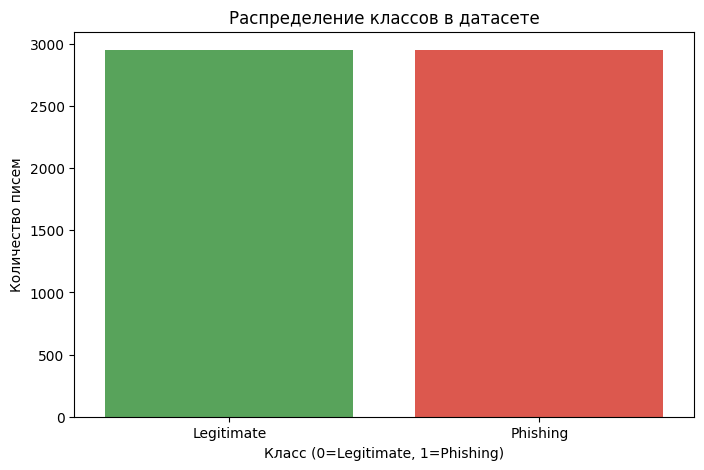


✓ Классы сбалансированы.


In [ ]:
# Проверка балансировки классов
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = pd.Series(y).value_counts()
class_percentages = pd.Series(y).value_counts(normalize=True) * 100

print("Распределение классов:")
print(f"  Legitimate (0): {class_counts.get(0, 0)} ({class_percentages.get(0, 0):.2f}%)")
print(f"  Phishing (1): {class_counts.get(1, 0)} ({class_percentages.get(1, 0):.2f}%)")

# Визуализация
plt.figure(figsize=(8, 5))
sns.countplot(x=y, palette=['#4CAF50', '#F44336'])
plt.title('Распределение классов в датасете')
plt.xlabel('Класс (0=Legitimate, 1=Phishing)')
plt.ylabel('Количество писем')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.show()

# Если классы несбалансированы, можно применить балансировку
if abs(class_percentages.get(0, 0) - class_percentages.get(1, 0)) > 5:
    print("\n Классы несбалансированы. Рекомендуется балансировка.")
else:
    print("\nКлассы сбалансированы.")


## 9. Разделение данных на train/validation/test

Разделение датасета на три части:
- **70%** train — для обучения моделей
- **15%** validation — для подбора гиперпараметров
- **15%** test — для финальной оценки (резерв)

Используется стратифицированное разделение для сохранения пропорций классов.


In [79]:
# Разделение на train (70%) и временный набор (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# Разделение временного набора на validation (15%) и test (15%)
# test_size = 0.5 означает, что из 30% мы берем 50%, т.е. 15% от исходного
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print("Разделение данных завершено:")
print(f"  Train:      {X_train.shape[0]} образцов ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation: {X_val.shape[0]} образцов ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test:       {X_test.shape[0]} образцов ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nРаспределение классов в train:")
print(f"  Legitimate: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  Phishing:   {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")

print(f"\nРаспределение классов в validation:")
print(f"  Legitimate: {np.sum(y_val == 0)} ({np.sum(y_val == 0)/len(y_val)*100:.1f}%)")
print(f"  Phishing:   {np.sum(y_val == 1)} ({np.sum(y_val == 1)/len(y_val)*100:.1f}%)")

print(f"\nРаспределение классов в test:")
print(f"  Legitimate: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  Phishing:   {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")


Разделение данных завершено:
  Train:      4128 образцов (70.0%)
  Validation: 885 образцов (15.0%)
  Test:       885 образцов (15.0%)

Распределение классов в train:
  Legitimate: 2065 (50.0%)
  Phishing:   2063 (50.0%)

Распределение классов в validation:
  Legitimate: 442 (49.9%)
  Phishing:   443 (50.1%)

Распределение классов в test:
  Legitimate: 443 (50.1%)
  Phishing:   442 (49.9%)


## 10. Сохранение обработанных данных

Сохранение разделенных данных и обученного векторизатора в pickle файлы для использования в `model_training.ipynb`.


In [84]:
# Создание директории для сохранения
MODELS_DIR = BASE_DIR / 'data' / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Сохранение train.pkl
print("Сохранение train.pkl...")
with open(MODELS_DIR / 'train.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'y_train': y_train
    }, f)
print(f"✓ train.pkl сохранен: {MODELS_DIR / 'train.pkl'}")

# Сохранение val.pkl
print("Сохранение val.pkl...")
with open(MODELS_DIR / 'val.pkl', 'wb') as f:
    pickle.dump({
        'X_val': X_val,
        'y_val': y_val
    }, f)
print(f"✓ val.pkl сохранен: {MODELS_DIR / 'val.pkl'}")

# Сохранение test.pkl
print("Сохранение test.pkl...")
with open(MODELS_DIR / 'test.pkl', 'wb') as f:
    pickle.dump({
        'X_test': X_test,
        'y_test': y_test
    }, f)
print(f"✓ test.pkl сохранен: {MODELS_DIR / 'test.pkl'}")

# Сохранение обученного TF-IDF векторизатора и scaler
print("Сохранение tfidf_vectorizer.pkl...")
feature_extractor.save_vectorizer(str(MODELS_DIR / 'tfidf_vectorizer.pkl'))
print(f"✓ tfidf_vectorizer.pkl сохранен: {MODELS_DIR / 'tfidf_vectorizer.pkl'}")

print("\nВсе файлы успешно сохранены!")


Сохранение train.pkl...
✓ train.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\train.pkl
Сохранение val.pkl...
✓ val.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\val.pkl
Сохранение test.pkl...
✓ test.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\test.pkl
Сохранение tfidf_vectorizer.pkl...
✓ tfidf_vectorizer.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\tfidf_vectorizer.pkl

Все файлы успешно сохранены!


In [4]:
MODELS_DIR = BASE_DIR / 'data' / 'models'

In [5]:
# Можно ли вывести параметры из сохранённых файлов? — Да! Пример ниже:
import pickle

# Загружаем tfidf_vectorizer и scaler из файла
with open(MODELS_DIR / 'tfidf_vectorizer.pkl', 'rb') as f:
    vect_data = pickle.load(f)

vectorizer = vect_data['vectorizer']
scaler = vect_data.get('scaler', None)

print("="*40)
print("Параметры tfidf_vectorizer (из файла):")
vocab_size = len(vectorizer.vocabulary_)
print(f"  Размер словаря: {vocab_size}")
print(f"  n_features: {vectorizer.max_features}")
print(f"  min_df: {vectorizer.min_df}")
print(f"  max_df: {vectorizer.max_df}")
print(f"  ngram_range: {vectorizer.ngram_range}")

# Аналогично, можно узнать размерность X_train, X_val, X_test из их файлов:
with open(MODELS_DIR / 'train.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open(MODELS_DIR / 'val.pkl', 'rb') as f:
    val_data = pickle.load(f)
with open(MODELS_DIR / 'test.pkl', 'rb') as f:
    test_data = pickle.load(f)

print("\nРазмерности массивов/датасетов (из файлов):")
print(f"  X_train: {getattr(train_data['X_train'], 'shape', 'нет атрибута shape')}")
print(f"  y_train: {getattr(train_data['y_train'], 'shape', 'нет атрибута shape')}")
print(f"  X_val: {getattr(val_data['X_val'], 'shape', 'нет атрибута shape')}")
print(f"  y_val: {getattr(val_data['y_val'], 'shape', 'нет атрибута shape')}")
print(f"  X_test: {getattr(test_data['X_test'], 'shape', 'нет атрибута shape')}")
print(f"  y_test: {getattr(test_data['y_test'], 'shape', 'нет атрибута shape')}")
print("="*40)

Параметры tfidf_vectorizer (из файла):
  Размер словаря: 5000
  n_features: 5000
  min_df: 2
  max_df: 0.95
  ngram_range: (1, 2)

Размерности массивов/датасетов (из файлов):
  X_train: (4128, 5010)
  y_train: (4128,)
  X_val: (885, 5010)
  y_val: (885,)
  X_test: (885, 5010)
  y_test: (885,)


In [ ]:
X_train = train_data['X_train']
y_train = train_data['y_train']
X_val = val_data['X_val']
y_val = val_data['y_val']
X_test = test_data['X_test']
y_test = test_data['y_test']

# Конвертация в sparse matrix
from scipy.sparse import csr_matrix

X_train = csr_matrix(X_train)
X_val = csr_matrix(X_val)
X_test = csr_matrix(X_test)

In [11]:
# Сохранение данных в sparse формате
print("Сохранение train.pkl (sparse format)...")
with open(MODELS_DIR / 'train.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'y_train': y_train
    }, f)
print(f"✓ train.pkl сохранен: {MODELS_DIR / 'train.pkl'}")

print("Сохранение val.pkl (sparse format)...")
with open(MODELS_DIR / 'val.pkl', 'wb') as f:
    pickle.dump({
        'X_val': X_val,
        'y_val': y_val
    }, f)
print(f"✓ val.pkl сохранен: {MODELS_DIR / 'val.pkl'}")

print("Сохранение test.pkl (sparse format)...")
with open(MODELS_DIR / 'test.pkl', 'wb') as f:
    pickle.dump({
        'X_test': X_test,
        'y_test': y_test
    }, f)
print(f"✓ test.pkl сохранен: {MODELS_DIR / 'test.pkl'}")

print("\nВсе файлы успешно сохранены в sparse формате")


Сохранение train.pkl (sparse format)...
✓ train.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\train.pkl
Сохранение val.pkl (sparse format)...
✓ val.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\val.pkl
Сохранение test.pkl (sparse format)...
✓ test.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\test.pkl

Все файлы успешно сохранены в sparse формате


In [8]:
print(f"Тип X_train: {type(X_train)}")
print(f"Формат: {X_train.__class__.__name__}")

Тип X_train: <class 'numpy.ndarray'>
Формат: ndarray


In [9]:
from scipy.sparse import issparse, csr_matrix


In [10]:
issparse(X_train)

False